## In this notebook:
* Analysis of TCGA dataset containing gene expression values for both normal and cancer cells.
* Cancer type is clear cell renal carcinoma (kidney cancer)
* The dataset can be found at: https://tcga.xenahubs.net/download/TCGA.KIRC.sampleMap/HiSeqV2.gz
* Brief discussion of the goal of this project and the workflow
* Data wrangling
* Data filtering
* EDA
* Differential expression analysis
* Correlation analysis
* Unsupervised learning
* Interpretation of results

### Analysis of TCGA gene expression dataset for clear cell renal carcinoma.

The goal of this analysis is to find differences in gene expression profiles between the two sample populations: normal cells vs cancer cells. The two groups will be compared through an analysis of a gene expression dataset downloaded from The Cancer Genome Atlas (TCGA). The dataset contains expression values (sequence counts) generated via the Illumina HiSeq platform. 


### Summary of the Differential Expression Analysis Workflow:

1) Involves identifying genes whose expression levels change between two sample groups.

2) We begin by importing our dataset and necessary packages.

3) Then, we can reduce our dataset by filtering out all genes with zero values.

4) Next, we can split our dataset using regular expressions:

    a) Expression values for cancer cells in one dataframe
    
    b) Expression values for normal cells in another dataframe

5) Because the dataset has already been normalized and log(2) transformed, no additional preprocessing is required

6) We can further truncate our dataset using the IQR method. However, for this demonstration, we only reduce the dataset through filtering out all genes with zero values. 

7) The differential expression (DE) workflow:

    a) Calculate the mean for each row (or each gene) in both dataframes
    
    b) calculate the variance for each row in both dataframes
    
    c) Calculate the t-statistic for each gene across both dataframes
    
    d) Because we have a large number of replicates for each group and only two groups, the t-statistic can be used

8) Show the top 25 differentially expressed genes.

### Purpose and intended audience
* The purpose of this project is to demonstrate pythonic techniques for performing basic gene expression analysis.
* This can be useful to novice bioinformaticians and enthusiasts interested in gene expression analysis.
* Some caveats:
    * Differential expression analysis was performed using the t-statistic method. While the t-test method is suitable in this case because of the size of the dataset, a more generalized technique would utilize Bayesian based methods
    * While hierarchical clustering is one way to find coexpression networks, there are packages specifically designed to perform this function. Many Bioconductor packages (designed for the R programming language) can be called from python using the rpy2 module. Good packages for differential expression and coexpression analysis include edgeR and WGCNA

## Data wrangling

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
 
%matplotlib inline
 
print("Current working directory" , os.getcwd()) # print out current working directory

Current working directory C:\Users\Frank


### Read in data and print header

In [2]:
os.chdir('c:/users/frank/desktop/python_springboard/datasets')

In [3]:
filename = 'HiSeqV2.csv' # assign dataset to filename object
data = pd.read_csv(filename, sep = ',') # read in csv file as pandas dataframe

In [4]:
data = data.set_index('sample')

In [5]:
data.head() # print head to verify proper formatting 

,TCGA-BP-4162-01,TCGA-CJ-5677-11,TCGA-DV-5566-01,TCGA-BP-5191-01,TCGA-BP-5200-01,TCGA-BP-4347-01,TCGA-BP-4770-01,TCGA-B0-5696-11,TCGA-BP-4762-01,TCGA-BP-4158-01,...,TCGA-B0-5104-01,TCGA-A3-3313-01,TCGA-B2-5633-01,TCGA-CJ-4872-01,TCGA-CJ-5684-01,TCGA-CJ-4886-01,TCGA-BP-5009-01,TCGA-BP-4969-01,TCGA-CZ-5461-01,TCGA-CW-5587-01
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,10.5030,10.8969,10.7612,10.2063,10.0616,10.0193,8.4364,11.1427,9.9150,10.7621,...,10.5586,9.5556,10.2652,9.4981,10.2751,9.9525,10.1273,10.8817,10.1949,10.3294
HIF3A,5.5283,6.4943,5.7842,5.0063,5.3326,7.6102,6.0422,5.9789,3.7802,7.2039,...,6.2061,4.8253,5.1680,8.6195,6.2080,6.3116,6.7446,7.8293,6.1788,6.2293
RNF17,3.8036,0.0000,0.0000,0.0000,0.0000,0.3386,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6128,0.0000
RNF10,11.4379,12.2130,11.5478,12.3439,11.5149,11.4065,12.1963,12.3946,11.3734,11.3251,...,11.7338,11.7709,11.4968,11.9561,11.7518,11.5698,12.1565,11.3048,11.5168,11.3489
RNF11,11.4180,11.8248,11.3190,10.3413,11.2923,10.9971,11.8936,11.7217,12.2329,11.2993,...,11.7629,10.2373,11.4637,11.4391,11.3992,11.4937,11.4015,10.8842,11.6230,11.5469


### Drop rows with zero values

In [6]:
df_replace = data.replace(0.0000, np.nan)
df_dropped = df_replace.dropna(axis=0, how='any')
df_dropped.shape

(12580, 606)

### Split data into two dataframes:
* The first dataframe (df1) contains expression values for normal cells
* The second dataframe (df2) contains expression values for cancer cells

In [7]:
df1 = df_dropped.filter(regex = 'sample|11$', axis =1)
# Creating new dataframe with only columns containing expression values for normal cells

In [8]:
df1.shape

(12580, 72)

In [9]:
df1.head()

,TCGA-CJ-5677-11,TCGA-B0-5696-11,TCGA-CJ-5679-11,TCGA-CZ-5452-11,TCGA-B0-5712-11,TCGA-CW-5584-11,TCGA-B0-5701-11,TCGA-CZ-5461-11,TCGA-B0-5690-11,TCGA-CZ-5468-11,...,TCGA-CW-5580-11,TCGA-B8-5552-11,TCGA-CZ-4865-11,TCGA-CZ-4863-11,TCGA-B2-5636-11,TCGA-CW-6088-11,TCGA-CZ-5982-11,TCGA-CZ-5469-11,TCGA-CJ-5678-11,TCGA-CZ-5451-11
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,10.8969,11.1427,10.3362,10.9979,10.6467,10.6163,10.6772,10.5352,10.9610,10.8893,...,10.8603,9.4288,10.3868,10.2874,10.9476,10.8848,10.7783,10.3262,10.4025,10.9598
HIF3A,6.4943,5.9789,6.0228,7.8769,8.5452,5.1819,8.6367,4.9484,7.1702,7.2163,...,8.3424,5.5908,7.9224,7.5603,6.4780,8.5598,6.5021,6.9556,5.5893,6.8364
RNF10,12.2130,12.3946,12.3002,12.4976,12.1206,12.1293,12.1640,12.2868,12.2738,12.2829,...,12.4214,11.3729,11.9933,11.9568,12.1550,12.4600,12.0911,12.3941,12.0396,12.2514
RNF11,11.8248,11.7217,12.0602,11.6335,11.8102,11.6994,11.5128,11.9681,11.5019,11.7200,...,11.6284,12.6320,11.9769,11.9774,11.6255,11.4753,11.9079,11.7476,11.9066,11.7847
RNF13,10.7779,10.8412,10.8172,10.9679,10.7033,10.6184,10.7271,11.0801,10.9754,10.7149,...,11.0227,11.2715,11.0244,10.7831,10.8893,10.9174,10.8537,10.6932,11.0341,10.9808


In [10]:
df2 = df_dropped.filter(regex = 'sample|01|05$', axis = 1)
# Creating new dataframe with only columns containing expression values for cancer cells

In [11]:
df2.shape

(12580, 535)

In [12]:
df2.head()

,TCGA-BP-4162-01,TCGA-DV-5566-01,TCGA-BP-5191-01,TCGA-BP-5200-01,TCGA-BP-4347-01,TCGA-BP-4770-01,TCGA-BP-4762-01,TCGA-BP-4158-01,TCGA-CJ-4887-01,TCGA-B2-4098-01,...,TCGA-B0-5104-01,TCGA-A3-3313-01,TCGA-B2-5633-01,TCGA-CJ-4872-01,TCGA-CJ-5684-01,TCGA-CJ-4886-01,TCGA-BP-5009-01,TCGA-BP-4969-01,TCGA-CZ-5461-01,TCGA-CW-5587-01
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,10.5030,10.7612,10.2063,10.0616,10.0193,8.4364,9.9150,10.7621,10.5819,9.9260,...,10.5586,9.5556,10.2652,9.4981,10.2751,9.9525,10.1273,10.8817,10.1949,10.3294
HIF3A,5.5283,5.7842,5.0063,5.3326,7.6102,6.0422,3.7802,7.2039,6.1342,1.9065,...,6.2061,4.8253,5.1680,8.6195,6.2080,6.3116,6.7446,7.8293,6.1788,6.2293
RNF10,11.4379,11.5478,12.3439,11.5149,11.4065,12.1963,11.3734,11.3251,11.7681,11.7520,...,11.7338,11.7709,11.4968,11.9561,11.7518,11.5698,12.1565,11.3048,11.5168,11.3489
RNF11,11.4180,11.3190,10.3413,11.2923,10.9971,11.8936,12.2329,11.2993,10.8723,10.4091,...,11.7629,10.2373,11.4637,11.4391,11.3992,11.4937,11.4015,10.8842,11.6230,11.5469
RNF13,11.1265,10.7718,10.4809,10.8360,10.2079,9.7629,11.1625,10.6960,10.8856,11.5110,...,11.2131,11.5131,11.0412,11.1944,10.9735,11.1726,10.9264,10.9815,10.7416,11.0906


## Generate density plots to confirm the shape of the distribution

#### KDE plots of processed data separated by sample type (cancer/normal)

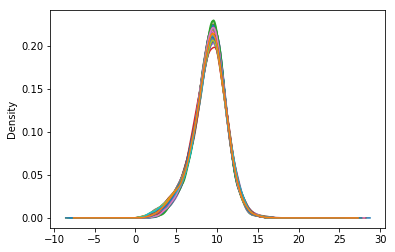

In [20]:
df1.plot(kind='kde', legend=False) # normal cells

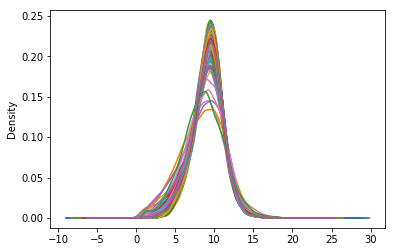

In [23]:
df2.plot(kind='kde', legend=False) # cancer cells

## Pythonic differential expression analysis

In [13]:
import warnings
warnings.simplefilter("ignore")
from scipy.stats import ttest_ind, ttest_ind_from_stats


df1['mean1'] = df1[df1.columns].mean(axis=1)
df1['variance1'] = df1[df1.columns].var(axis=1)
df2['mean2'] = df2[df2.columns].mean(axis=1)
df2['variance2'] = df2[df2.columns].var(axis=1)



In [14]:
df1.head()

,TCGA-CJ-5677-11,TCGA-B0-5696-11,TCGA-CJ-5679-11,TCGA-CZ-5452-11,TCGA-B0-5712-11,TCGA-CW-5584-11,TCGA-B0-5701-11,TCGA-CZ-5461-11,TCGA-B0-5690-11,TCGA-CZ-5468-11,...,TCGA-CZ-4865-11,TCGA-CZ-4863-11,TCGA-B2-5636-11,TCGA-CW-6088-11,TCGA-CZ-5982-11,TCGA-CZ-5469-11,TCGA-CJ-5678-11,TCGA-CZ-5451-11,mean1,variance1
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,10.8969,11.1427,10.3362,10.9979,10.6467,10.6163,10.6772,10.5352,10.9610,10.8893,...,10.3868,10.2874,10.9476,10.8848,10.7783,10.3262,10.4025,10.9598,10.587401,0.124498
HIF3A,6.4943,5.9789,6.0228,7.8769,8.5452,5.1819,8.6367,4.9484,7.1702,7.2163,...,7.9224,7.5603,6.4780,8.5598,6.5021,6.9556,5.5893,6.8364,6.844586,0.760941
RNF10,12.2130,12.3946,12.3002,12.4976,12.1206,12.1293,12.1640,12.2868,12.2738,12.2829,...,11.9933,11.9568,12.1550,12.4600,12.0911,12.3941,12.0396,12.2514,12.214072,0.057677
RNF11,11.8248,11.7217,12.0602,11.6335,11.8102,11.6994,11.5128,11.9681,11.5019,11.7200,...,11.9769,11.9774,11.6255,11.4753,11.9079,11.7476,11.9066,11.7847,11.827933,0.047012
RNF13,10.7779,10.8412,10.8172,10.9679,10.7033,10.6184,10.7271,11.0801,10.9754,10.7149,...,11.0244,10.7831,10.8893,10.9174,10.8537,10.6932,11.0341,10.9808,10.933962,0.038483


In [15]:
df2.head()

,TCGA-BP-4162-01,TCGA-DV-5566-01,TCGA-BP-5191-01,TCGA-BP-5200-01,TCGA-BP-4347-01,TCGA-BP-4770-01,TCGA-BP-4762-01,TCGA-BP-4158-01,TCGA-CJ-4887-01,TCGA-B2-4098-01,...,TCGA-B2-5633-01,TCGA-CJ-4872-01,TCGA-CJ-5684-01,TCGA-CJ-4886-01,TCGA-BP-5009-01,TCGA-BP-4969-01,TCGA-CZ-5461-01,TCGA-CW-5587-01,mean2,variance2
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,10.5030,10.7612,10.2063,10.0616,10.0193,8.4364,9.9150,10.7621,10.5819,9.9260,...,10.2652,9.4981,10.2751,9.9525,10.1273,10.8817,10.1949,10.3294,10.132370,0.506471
HIF3A,5.5283,5.7842,5.0063,5.3326,7.6102,6.0422,3.7802,7.2039,6.1342,1.9065,...,5.1680,8.6195,6.2080,6.3116,6.7446,7.8293,6.1788,6.2293,6.221919,2.489839
RNF10,11.4379,11.5478,12.3439,11.5149,11.4065,12.1963,11.3734,11.3251,11.7681,11.7520,...,11.4968,11.9561,11.7518,11.5698,12.1565,11.3048,11.5168,11.3489,11.675401,0.102617
RNF11,11.4180,11.3190,10.3413,11.2923,10.9971,11.8936,12.2329,11.2993,10.8723,10.4091,...,11.4637,11.4391,11.3992,11.4937,11.4015,10.8842,11.6230,11.5469,11.322741,0.198024
RNF13,11.1265,10.7718,10.4809,10.8360,10.2079,9.7629,11.1625,10.6960,10.8856,11.5110,...,11.0412,11.1944,10.9735,11.1726,10.9264,10.9815,10.7416,11.0906,10.980765,0.231565


In [16]:
df1_stats = df1[['mean1', 'variance1']]
df1_stats.head()

,mean1,variance1
sample,,
ARHGEF10L,10.587401,0.124498
HIF3A,6.844586,0.760941
RNF10,12.214072,0.057677
RNF11,11.827933,0.047012
RNF13,10.933962,0.038483


In [17]:
df2_stats = df2[['mean2', 'variance2']]
df2_stats.head()

,mean2,variance2
sample,,
ARHGEF10L,10.132370,0.506471
HIF3A,6.221919,2.489839
RNF10,11.675401,0.102617
RNF11,11.322741,0.198024
RNF13,10.980765,0.231565


In [18]:
df = pd.concat([df1_stats, df2_stats], axis=1)
df.head()

,mean1,variance1,mean2,variance2
sample,,,,
ARHGEF10L,10.587401,0.124498,10.132370,0.506471
HIF3A,6.844586,0.760941,6.221919,2.489839
RNF10,12.214072,0.057677,11.675401,0.102617
RNF11,11.827933,0.047012,11.322741,0.198024
RNF13,10.933962,0.038483,10.980765,0.231565


In [19]:
df1.shape

(12580, 74)

In [20]:
df2.shape

(12580, 537)

In [22]:
df['ttest'] = abs((df['mean1'] - df['mean2'])/(np.sqrt(df['variance1']/74 + df['variance2']/537)))

In [23]:
df.head()

,mean1,variance1,mean2,variance2,ttest
sample,,,,,
ARHGEF10L,10.587401,0.124498,10.132370,0.506471,8.880362
HIF3A,6.844586,0.760941,6.221919,2.489839,5.097743
RNF10,12.214072,0.057677,11.675401,0.102617,17.291094
RNF11,11.827933,0.047012,11.322741,0.198024,15.943227
RNF13,10.933962,0.038483,10.980765,0.231565,1.517467


In [24]:
diffexp_results = df['ttest']
diffexp = diffexp_results.sort_values(ascending=False)
diffexp.head()

sample
TFCP2L1     45.069861
PAK6        45.037406
SCNN1A      41.761799
PROM2       41.630070
NDUFA4L2    41.419890
Name: ttest, dtype: float64

## The top 25 differentially expressed genes:

In [25]:
results = diffexp.iloc[1:25]
results

sample
PAK6        45.037406
SCNN1A      41.761799
PROM2       41.630070
NDUFA4L2    41.419890
NOL3        41.102853
BRCC3       39.666073
SFRP1       39.578176
SCARB1      39.336044
C7orf68     39.328517
SLC15A4     38.738762
C20orf54    37.866042
GPC3        37.633499
DDB2        37.573465
PVT1        37.449893
ZNF395      36.747181
SPAG4       36.731714
GABRD       36.592500
KRBA1       36.530676
C20orf46    36.410145
EGLN3       36.152210
ESRRG       36.070852
AP1M2       36.035638
MECOM       35.674698
PIP4K2C     35.659240
Name: ttest, dtype: float64

## Unsupervised learning
* Create correlation matrices from our two dataframes
* Find genes closely correlated with our top 25 differentially expressed genes
* Perform hierarchical clustering with dendrograms

### Correlation analysis
* Transpose dataframes so gene names are column names
* Perform correlation analysis using corr()

In [13]:
df1_t = df1.T
correlations1 = df1_t.corr()
correlations1.head()

sample,ARHGEF10L,HIF3A,RNF10,RNF11,RNF13,GTF2IP1,REM1,C16orf13,FGFR1OP2,ATRX,...,PLEKHG4,PLEKHG5,METTL11A,GNGT2,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,1.000000,0.088539,0.504560,-0.494848,-0.326119,0.014632,-0.281433,0.001963,-0.378481,-0.073747,...,-0.094584,-0.107983,0.016821,-0.229151,0.123411,-0.476159,-0.266823,0.308415,-0.367047,-0.390731
HIF3A,0.088539,1.000000,0.244048,-0.427758,-0.079045,0.356277,0.394656,-0.054083,0.006581,0.130943,...,0.314701,0.647484,-0.180974,0.434179,0.043715,0.297665,0.410983,-0.295219,0.230147,-0.051497
RNF10,0.504560,0.244048,1.000000,-0.629701,-0.355883,0.321195,-0.211260,0.010898,-0.393613,-0.068529,...,-0.013854,0.149296,0.142773,0.209445,0.188196,-0.175391,0.082177,0.002233,-0.260518,-0.120385
RNF11,-0.494848,-0.427758,-0.629701,1.000000,0.579714,-0.202761,0.108012,-0.029901,0.667951,-0.156077,...,-0.255825,-0.347220,0.125224,-0.176621,-0.192151,0.011305,-0.246639,0.094886,0.139253,0.344551
RNF13,-0.326119,-0.079045,-0.355883,0.579714,1.000000,-0.039893,0.105697,0.197477,0.553414,-0.202017,...,-0.135304,-0.238546,0.086648,0.252588,-0.143277,-0.147739,-0.217032,0.369063,0.145549,0.267679


In [14]:
# reduce number of replicates to 74 to improve computational efficiency
df2 = df2.iloc[:,0:74]
df2.shape

(12580, 74)

In [15]:
df2_t = df2.T
correlations2 = df2_t.corr()
correlations2.head()

sample,ARHGEF10L,HIF3A,RNF10,RNF11,RNF13,GTF2IP1,REM1,C16orf13,FGFR1OP2,ATRX,...,PLEKHG4,PLEKHG5,METTL11A,GNGT2,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,1.000000,0.024608,-0.173580,-0.241433,-0.087010,0.129747,0.116872,0.298257,-0.098879,-0.234766,...,0.116879,0.324520,-0.279668,0.091295,0.279363,0.153294,0.041579,0.077323,0.065454,-0.219571
HIF3A,0.024608,1.000000,-0.179497,-0.087668,-0.298205,-0.042542,0.129929,0.057476,-0.015399,0.122711,...,0.376146,0.386371,-0.290680,0.181297,0.247087,0.210081,0.247026,-0.231036,0.174809,-0.062993
RNF10,-0.173580,-0.179497,1.000000,0.079668,0.004473,0.245814,0.029143,0.047225,-0.203526,-0.259482,...,-0.186192,-0.262662,0.344579,-0.209520,-0.286742,-0.138825,-0.354226,0.378698,-0.076710,0.214445
RNF11,-0.241433,-0.087668,0.079668,1.000000,0.325274,-0.033927,0.020340,-0.240425,0.184659,0.226010,...,-0.220389,-0.234318,0.335986,-0.265711,-0.347088,-0.025457,0.134547,0.036823,0.053741,0.142740
RNF13,-0.087010,-0.298205,0.004473,0.325274,1.000000,-0.112549,-0.503279,-0.002180,0.048698,-0.012031,...,-0.508828,-0.622796,0.428826,-0.384353,-0.653723,-0.624539,-0.376590,0.415809,-0.276665,0.377531


### Create dataframes with correlated values for differentially expressed genes

In [16]:
diff_exp1 = correlations1[['PAK6', 'SCNN1A', 'PROM2', 'NDUFA4L2', 'NOL3', 'BRCC3', 'SFRP1', 'SCARB1', 'C7orf68', 'SLC15A4', 'C20orf54', 'GPC3', 'DDB2', 'PVT1', 'ZNF395', 'SPAG4', 'GABRD', 'KRBA1', 'C20orf46', 'EGLN3', 'ESRRG', 'AP1M2', 'MECOM', 'PIP4K2C']]

In [17]:
diff_exp2 = correlations2[['PAK6', 'SCNN1A', 'PROM2', 'NDUFA4L2', 'NOL3', 'BRCC3', 'SFRP1', 'SCARB1', 'C7orf68', 'SLC15A4', 'C20orf54', 'GPC3', 'DDB2', 'PVT1', 'ZNF395', 'SPAG4', 'GABRD', 'KRBA1', 'C20orf46', 'EGLN3', 'ESRRG', 'AP1M2', 'MECOM', 'PIP4K2C']]

In [37]:
diff_exp1.head()

sample,PAK6,SCNN1A,PROM2,NDUFA4L2,NOL3,BRCC3,SFRP1,SCARB1,C7orf68,SLC15A4,...,ZNF395,SPAG4,GABRD,KRBA1,C20orf46,EGLN3,ESRRG,AP1M2,MECOM,PIP4K2C
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,0.462992,0.298112,0.405765,-0.423682,0.037366,-0.049737,0.416652,-0.290435,-0.327374,-0.586508,...,0.069893,-0.436264,-0.215458,0.200281,-0.232417,-0.449357,0.497375,0.165519,0.262012,0.185536
HIF3A,0.079163,0.297473,0.285058,0.349468,0.025237,0.074457,-0.132598,-0.009497,0.077946,0.313484,...,-0.107264,0.065024,-0.156097,0.503901,0.198760,0.253032,0.023914,0.226002,0.289805,0.039085
RNF10,0.613143,0.790639,0.646532,-0.082588,-0.160660,0.045873,0.300530,-0.327142,-0.242301,-0.077738,...,-0.207564,-0.218299,-0.384885,0.418190,-0.165911,0.074628,0.514621,0.561839,0.670477,0.539039
RNF11,-0.271383,-0.496803,-0.313556,-0.155713,-0.049730,0.037801,-0.012216,-0.086254,0.029430,-0.035178,...,-0.122679,0.038662,0.046777,-0.667231,-0.091976,-0.127837,-0.147981,-0.176501,-0.369566,-0.210843
RNF13,-0.270159,-0.279792,-0.087431,0.030606,0.042169,0.080483,-0.080518,0.014018,0.014269,0.021012,...,-0.071146,0.052500,-0.119000,-0.333331,0.033403,0.062278,0.099544,0.019074,-0.219031,-0.233418


#### Create object with only highly correlated genes

In [18]:
top_corr1 = diff_exp1[(diff_exp1 > abs(0.85)).any(1)]
top_corr1.head()

sample,PAK6,SCNN1A,PROM2,NDUFA4L2,NOL3,BRCC3,SFRP1,SCARB1,C7orf68,SLC15A4,...,ZNF395,SPAG4,GABRD,KRBA1,C20orf46,EGLN3,ESRRG,AP1M2,MECOM,PIP4K2C
sample,,,,,,,,,,,,,,,,,,,,,
ATP1A1,0.711544,0.876018,0.794192,-0.197167,-0.397429,0.353746,0.389123,-0.506201,-0.411752,-0.026465,...,-0.434398,-0.330255,-0.607739,0.265544,-0.292214,0.169768,0.678454,0.727423,0.766842,0.708971
CPEB3,0.684401,0.701467,0.872120,-0.298592,-0.519584,0.408381,0.365096,-0.637028,-0.570723,-0.233942,...,-0.459543,-0.583709,-0.554876,0.053800,-0.478627,-0.051811,0.706338,0.522125,0.799289,0.644426
ZNF395,-0.639926,-0.531722,-0.569681,0.427154,0.711064,-0.406285,-0.548279,0.668486,0.552720,0.033160,...,1.000000,0.343584,0.652396,0.372049,0.447392,0.113705,-0.247935,-0.510516,-0.455818,-0.533998
C20orf54,0.588780,0.626409,0.415486,-0.184988,-0.505193,0.299537,0.304586,-0.437505,-0.116068,0.157149,...,-0.510458,-0.121678,-0.435177,0.066678,-0.331375,0.073452,0.174899,0.515987,0.475347,0.548629
MECOM,0.716721,0.843377,0.826658,-0.112045,-0.597350,0.463756,0.339606,-0.576760,-0.436602,-0.014581,...,-0.455818,-0.403288,-0.485351,0.199213,-0.367506,0.130202,0.586853,0.624192,1.000000,0.773251


In [19]:
top_corr1.shape

(76, 24)

In [20]:
top_corr2 = diff_exp2[(diff_exp2 > abs(0.85)).any(1)]
top_corr2.head()

sample,PAK6,SCNN1A,PROM2,NDUFA4L2,NOL3,BRCC3,SFRP1,SCARB1,C7orf68,SLC15A4,...,ZNF395,SPAG4,GABRD,KRBA1,C20orf46,EGLN3,ESRRG,AP1M2,MECOM,PIP4K2C
sample,,,,,,,,,,,,,,,,,,,,,
ZNF395,-0.616417,-0.537473,-0.452849,0.737766,0.652725,-0.463126,-0.282398,0.709449,0.745167,0.645932,...,1.000000,0.477332,0.509658,0.650860,-0.035048,0.781615,-0.357258,-0.358598,-0.429813,-0.705791
C20orf54,0.476759,0.529248,0.678341,-0.219027,-0.371124,0.022301,0.234753,-0.351003,-0.320675,-0.268541,...,-0.406138,-0.107888,-0.051697,-0.287525,0.035280,-0.345311,0.364415,0.394784,0.503531,0.270418
MECOM,0.560756,0.436675,0.493169,-0.454371,-0.577105,0.233805,0.413084,-0.541267,-0.486645,-0.464433,...,-0.429813,-0.584075,-0.049003,-0.255801,-0.127950,-0.500002,0.343437,0.101152,1.000000,0.466970
SLC15A4,-0.576119,-0.559316,-0.380270,0.597680,0.681140,-0.488333,-0.276511,0.669614,0.725495,1.000000,...,0.645932,0.533102,0.403242,0.583582,-0.101100,0.630409,-0.330574,-0.327745,-0.464433,-0.636075
BRCC3,0.435326,0.323508,0.158575,-0.623528,-0.635873,1.000000,0.176009,-0.487452,-0.545821,-0.488333,...,-0.463126,-0.628118,-0.473760,-0.568334,0.025446,-0.519194,0.083279,0.170446,0.233805,0.513536


In [21]:
top_corr2.shape

(26, 24)

### Hierarchical clustering
* Import packages
* Create separate objects for values and indexes of correlation data
* Create dendrograms

In [24]:
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from pylab import rcParams
import sklearn

In [38]:
topcorr_values1 = top_corr1.values
topcorr_index1 = top_corr1.index


In [39]:
Z = linkage(topcorr_values1, 'ward')


### Dendrogram of hierarchical clustering of differentially expressed genes correlated with normal cell samples

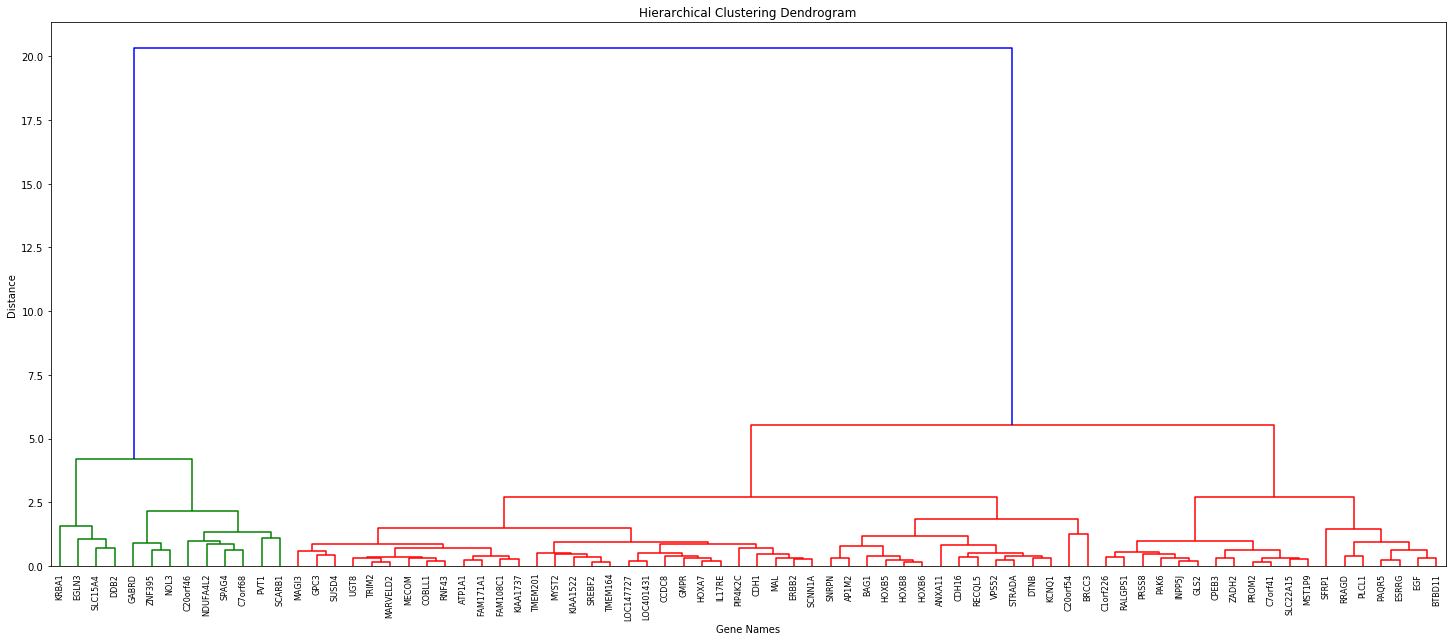

In [40]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Gene Names')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels = topcorr_index1
)
plt.show()

In [41]:
topcorr_values2 = top_corr2.values
topcorr_index2 = top_corr2.index

In [42]:
Z2 = linkage(topcorr_values2, 'ward')


### Dendrogram of hierarchical clustering of differentially expressed genes correlated with cancer cell samples

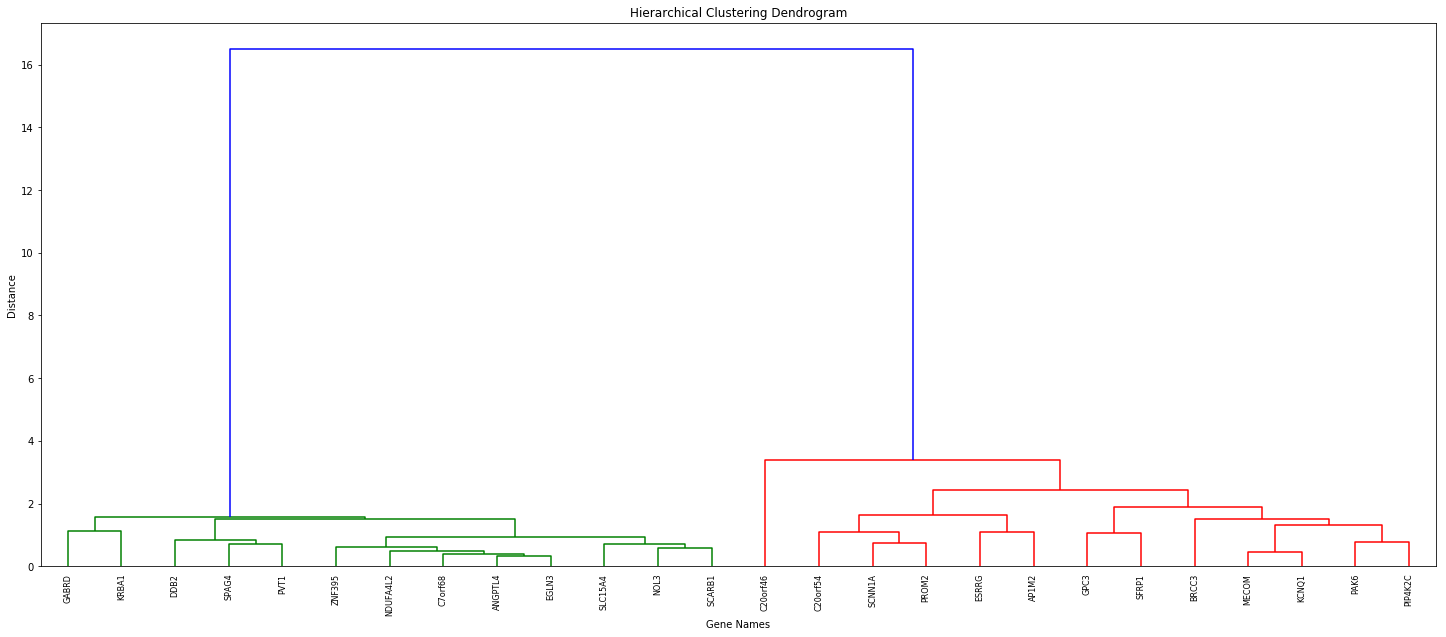

In [43]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Gene Names')
plt.ylabel('Distance')
dendrogram(
    Z2,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels = topcorr_index2
)
plt.show()

## Analysis of results